In [1]:
# from sklearn.decomposition import RandomizedPCA, PCA, TruncatedSVD
# from sklearn.linear_model import LogisticRegression
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler

import csv
import re
import matplotlib
import seaborn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import scipy.stats as ss
from matplotlib import style, colors
from matplotlib.lines import Line2D
import html5lib
# import beautifulsoup4 as bs4
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib_venn import venn2, venn3, venn3_circles
# from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list, cophenet
# from scipy.spatial.distance import pdist
#pretty display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)


# %config InlineBackend.figure_format = 'retina'
# figure out number of indels

In [2]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/101_patients/HIGH_MODERATE_SNV_summary_with_normal_with_AF_filtered.tsv.header.removed.comut.hiv.sorted'
df = pd.read_csv(f, sep='\t')
df.head()

,clinic_or_genes,patient,clinic_or_mutations
0,Histology,HTMCP-03-06-02007,Adeno
1,Histology,HTMCP-03-06-02026,Adeno
2,Histology,HTMCP-03-06-02047,Adeno
3,Histology,HTMCP-03-06-02074,Adeno
4,Histology,HTMCP-03-06-02075,Adeno


In [16]:
df.shape

(3737, 3)

In [ ]:
for grp, k in df.groupby('clinic_or_genes')['clinic_or_mutations':
    print(grp)
    print(k)

In [3]:
genes = df.groupby('clinic_or_genes')['clinic_or_mutations'].count().sort_values(ascending=False).index.tolist()

In [4]:
df1 = (df.groupby(['clinic_or_genes', 'patient'])['clinic_or_mutations']).max().unstack().fillna(0)

In [5]:
df1.head()

patient,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02026,...,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02322,HTMCP-03-06-02326,HTMCP-03-06-02328,HTMCP-03-06-02330,HTMCP-03-06-02332,HTMCP-03-06-02333
clinic_or_genes,,,,,,,,,,,,,,,,,,,,,
AJUBA,0,0,0,0,NON_SYNONYMOUS_CODING,0,0,0,0,0,...,FRAME_SHIFT,0,Multiple,0,0,0,0,0,0,0
ARID1A,0,0,0,0,NON_SYNONYMOUS_CODING,0,0,0,0,STOP_GAINED,...,0,0,0,0,0,NON_SYNONYMOUS_CODING,0,0,0,0
ATR,0,0,0,0,Multiple,0,0,0,0,STOP_GAINED,...,0,0,0,0,STOP_GAINED,0,0,0,0,0
ATRX,0,0,0,0,Multiple,0,0,STOP_GAINED,0,NON_SYNONYMOUS_CODING,...,0,0,0,0,0,0,0,0,0,0
B2M,0,0,0,0,NON_SYNONYMOUS_CODING,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# find out unique values in a dataframe
pd.Series(df1.values.ravel()).unique()# or # df1.stack().unique()
df1.stack().value_counts()


array([0, 'NON_SYNONYMOUS_CODING', 'FRAME_SHIFT', 'Multiple',
       'STOP_GAINED', 'Positive', 'Negative', 'SPLICE_ACCEPTOR_DONOR',
       'Squamous', 'Adeno', 'CODON_DELETION'], dtype=object)

0                        3210
NON_SYNONYMOUS_CODING     229
Squamous                   79
Positive                   51
Negative                   50
STOP_GAINED                44
Multiple                   30
Adeno                      22
FRAME_SHIFT                15
SPLICE_ACCEPTOR_DONOR       6
CODON_DELETION              1
dtype: int64

In [7]:
# map features to numbers
map_dict = {'SPLICE_ACCEPTOR_DONOR':0.95,
            'CODON_DELETION': 0.65,
            'STOP_GAINED': 1.05,
            #'no_mutation': 1.1,
            'NON_SYNONYMOUS_CODING':0.55,
            'Multiple':0.75,
            'FRAME_SHIFT':0.85,
           'Squamous':0.25,
            'Adeno':0.15,
           'Positive':0.45,
           'Negative':0.35,
           0:0.05}

In [8]:
df1 = df1.apply(lambda x: x.map(map_dict))

In [9]:
pd.Series(df1.values.ravel()).unique()

array([ 0.05,  0.55,  0.85,  0.75,  1.05,  0.45,  0.35,  0.95,  0.25,
        0.15,  0.65])

In [10]:
df1.head()

patient,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02026,...,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02322,HTMCP-03-06-02326,HTMCP-03-06-02328,HTMCP-03-06-02330,HTMCP-03-06-02332,HTMCP-03-06-02333
clinic_or_genes,,,,,,,,,,,,,,,,,,,,,
AJUBA,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,0.05,...,0.85,0.05,0.75,0.05,0.05,0.05,0.05,0.05,0.05,0.05
ARID1A,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,1.05,...,0.05,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05
ATR,0.05,0.05,0.05,0.05,0.75,0.05,0.05,0.05,0.05,1.05,...,0.05,0.05,0.05,0.05,1.05,0.05,0.05,0.05,0.05,0.05
ATRX,0.05,0.05,0.05,0.05,0.75,0.05,0.05,1.05,0.05,0.55,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
B2M,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


In [11]:
df1 = df1.reindex(index=genes).sort_values(genes, axis=1, ascending=False)

In [12]:
df1 = df1.drop('HTMCP-03-06-02061', axis=1)

In [13]:
df_pivot = df1.copy()

In [14]:
df_pivot.head(2)

patient,HTMCP-03-06-02260,HTMCP-03-06-02170,HTMCP-03-06-02070,HTMCP-03-06-02240,HTMCP-03-06-02001,HTMCP-03-06-02145,HTMCP-03-06-02120,HTMCP-03-06-02148,HTMCP-03-06-02268,HTMCP-03-06-02238,...,HTMCP-03-06-02075,HTMCP-03-06-02203,HTMCP-03-06-02047,HTMCP-03-06-02098,HTMCP-03-06-02085,HTMCP-03-06-02326,HTMCP-03-06-02157,HTMCP-03-06-02150,HTMCP-03-06-02182,HTMCP-03-06-02099
clinic_or_genes,,,,,,,,,,,,,,,,,,,,,
HIV,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45,...,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35
Histology,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,...,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15


In [15]:
lgds = sorted(map_dict, key=map_dict.get, reverse=False)
lgds.remove(0)

[]

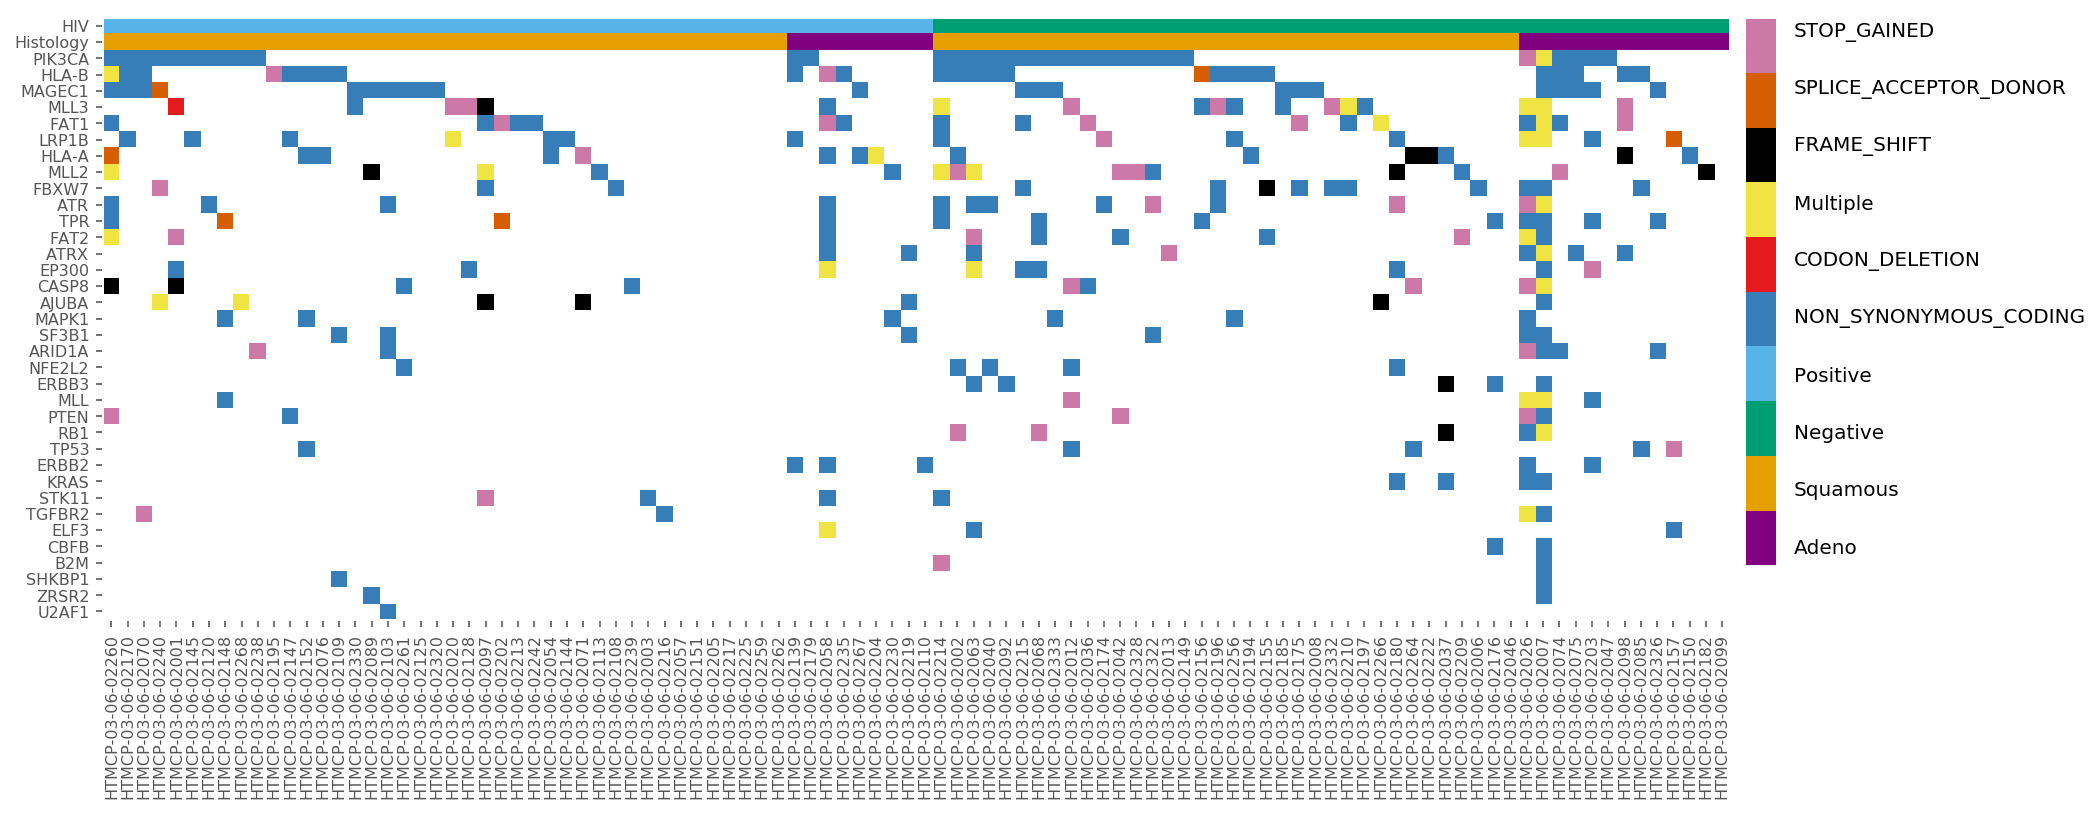

In [201]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(15, 9))

ax1 = fig.add_subplot(111)

clrs = ['white', "purple", "#E69F00","#009E73","#56B4E9","#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
# clrs = ['white',  'orange', 'purple','green',  'navy', 'red','blue', 'magenta' ]#"#0072B2",
bounds = np.arange(0, 1.2, 0.1).tolist()

# make a color map of fixed colors
cmap = colors.ListedColormap(clrs)
norm = colors.BoundaryNorm(bounds, cmap.N)
img = ax1.imshow(df_pivot.values, interpolation='none', origin='upper',
                    cmap=cmap, norm=norm)
ax1.grid(False)
_ = plt.yticks(np.arange(0, len(df_pivot.index), 1), df_pivot.index, fontsize=8)
_ = plt.xticks(np.arange(0, len(df_pivot.columns), 1), df_pivot.columns, fontsize=8, rotation=90)


# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(img, cax=ax2, cmap=cmap, norm=norm, boundaries=bounds, orientation='vertical')

cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(lgds):
    _ = cbar.ax.text(1.5, (2 * j + 2.5) / 21.0, lab, ha='left', va='center')
cbar.ax.get_yaxis().labelpad = 1
# cbar.ax.set_ylabel('', rotation=270)


of = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/101_patients/new_mutation_oncoprint.png'
# plt.savefig(of, bbox_inches='tight', dpi=300)